#CAPTCHA SOLVER

###USING CNN

We first will import our dataset from Kaggle, for that we would need to create a kaggle account and then import a kaggle.json file from our account to get access, this is basically a way to interract with kaggle API

In [1]:
!pip install Kaggle

In [2]:
!mkdir ~/.kaggle

Here we will upload our kaggle.json file

In [3]:
!cp kaggle.json ~/.kaggle

The following step gives read/write access to our kaggle.json file/ kaggle API

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download 'akashguna/large-captcha-dataset'

100% 825M/827M [00:40<00:00, 23.9MB/s]
100% 827M/827M [00:40<00:00, 21.6MB/s]


Here we will unzip our dataset

In [39]:
!unzip -d large-captcha-dataset.zip

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

After working with the dataset, I found that 1 particular file was creating issues so we'll remove it from our dataset


In [7]:
import os

directory = "Large_Captcha_Dataset"
filename = "4q2wA.png"
path = os.path.join(directory, filename)

if os.path.exists(path):
    os.remove(path)
    print("File removed successfully.")
else:
    print("File not found.")

File removed successfully.


Total size of the dataset

In [8]:
import os
import random

image_dir = 'Large_Captcha_Dataset'

image_files = [os.path.join(image_dir, file_name) for file_name in os.listdir(image_dir) if file_name.endswith(".jpg") or file_name.endswith(".png")]
print(f"len(image_files = {len(image_files)})")
random.shuffle(image_files)
selected_images = image_files[:82328]
print(f"len(selected_images = {len(selected_images)})")


len(image_files = 82328)
len(selected_images = 82328)


Using scikit image (skimage) to visualize the dataset

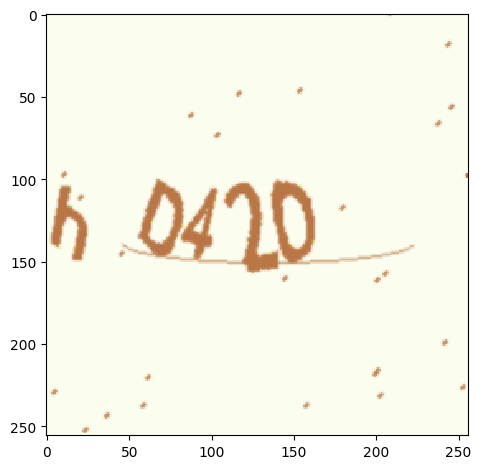

In [9]:
from skimage.io import imshow,imread,util
from skimage.transform import resize
from skimage import color,io,filters

imshow(imread(selected_images[0]))

Extracting the captcha labels (here filenames) from img directory and storing them in a list, this may take some time to complete

In [10]:
captcha_texts = []
for image_file in selected_images:
    try:
        temp_img = imread(image_file)
    except Exception as e:
        print(f"Error loading image file: {image_file}")
        print(f"Error message: {str(e)}")
        selected_images.remove(image_file)
        continue
    captcha_text = os.path.splitext(os.path.basename(image_file))[0]  # Extract the captcha text from the file name
    captcha_texts.append(captcha_text)

In [11]:
print(len(captcha_texts), len(selected_images))


82328 82328


Visualization using matplotlib

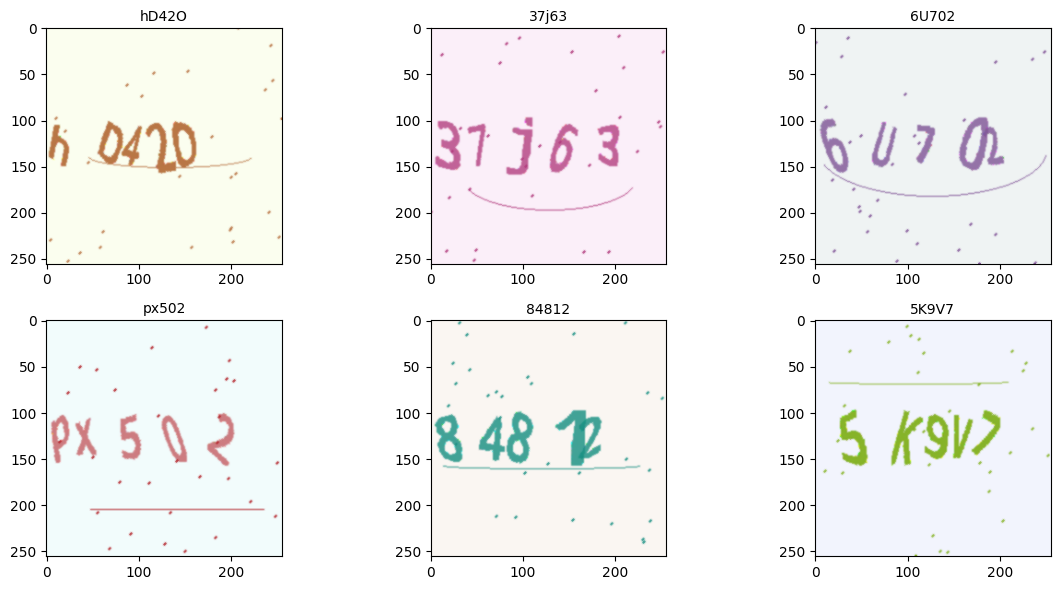

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i in range(6):
    ax = axes[i // 3, i % 3]  # Calculate the subplot index
    ax.imshow((imread(selected_images[-i])))
    ax.set_title(captcha_texts[-i], fontsize=10, pad=5)

plt.tight_layout()
plt.show()


In [13]:
print(selected_images[0])

Large_Captcha_Dataset/hD42O.png


Creating a dataframe

In [14]:
import pandas as pd
df = pd.DataFrame({'img_file': selected_images, 'label': captcha_texts})
df.head()

,img_file,label
0,Large_Captcha_Dataset/hD42O.png,hD42O
1,Large_Captcha_Dataset/fL4H4.png,fL4H4
2,Large_Captcha_Dataset/MVg08.png,MVg08
3,Large_Captcha_Dataset/r8233.png,r8233
4,Large_Captcha_Dataset/Nn9Q5.png,Nn9Q5


For training the model, we can't directly feed the captcha labels (text) as the targets, we would need something that is computably efficient, so we use '***One Hot Encoding***' to encode our captcha labels.

The following is a sample of how the 'to_categorical' function works:



1.  the ord('3') returns the ASCII number of '3' i.e. 51 in decimal
2.  the to_categorical function takes two parameters (x,y)
3.  we pass (3,128) as arguments to the function
4.  y is 128 because our focus is within the 1st 128 ASCII characters (0-9, a-z, A-Z)
5.  we see that the to_categorical function returns a numpy array with 0s except at the x position

This is 'One Hot Encoding'




In [15]:
from tensorflow.keras.utils import to_categorical
import numpy as np
print(np.array(to_categorical(ord('3'), 128)))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


Another example of what a section of the following code will be doing:
we are converting 3 np arrays returned by the to_categorical into one np array

In [16]:
print(np.array([np.array(to_categorical(i, 3)) for i in range(3)]))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Directly feeding the images and labels into the model for training which is a lot of imgs (82k) has a heavy toll on the RAM, at first I was using simple python lists with image file (np arrays) to feed as features to the model, my computer's memory shot up and it kept crashing, then I got to know about '***Data Generators***'.

Data Generators are functions that 'yeild'/ provide data in small batches rather than dumping all the data all at once, the following data generator creates data batches of batch_size size by taking size no. of images and labels, preprocessing them and feeding them to the model. Tensorflow's latest versions now also support input data(features) as data generator fucntions that yield data in batches.

This approach is used very often in cases where we work with large image/ video data. This will be light for the memory and work without any issues.

The following data generator function, takes the data frame 'df', indices of the data, and batch_size (default = 32), applies grayscale, resizing to the images, preprocesses labels and yields x_labels,y_labels.

In [17]:
from skimage import color
import numpy as np
resize_w_h = (200, 200)
def data_generator(df, indices, batch_size=32):
    while True:
        imgs, labels = [],[]
        batch_indices = np.random.choice(indices, size=batch_size, replace=False)

        for i in batch_indices:
            image_dir= df['img_file'].iloc[i]
            label = df['label'].iloc[i]

            #preprocessing the img
            img_file = imread(image_dir)
            img_file = color.rgb2gray(img_file)
            img_file = resize(img_file, resize_w_h, anti_aliasing=True) #preprocessing
            imgs.append(img_file)

            #preprocessing the label
            p_label = np.array([np.array(to_categorical(ord(i), 128)) for i in label])
            labels.append(p_label)
        batch_imgs = np.array(imgs)
        batch_labels = np.array(labels)

        yield batch_imgs, batch_labels

Then we define the split ratio for our dataset

In [18]:
## INDICES
train_ratio = 0.7
train_upto = int(len(selected_images)*train_ratio)
train_idx = np.arange(train_upto)
validation_ratio =train_ratio + 0.15
validation_upto = int(len(selected_images)*validation_ratio)
validation_idx = np.arange(train_upto, validation_upto)
test_idx =
print(train_idx)

[    0     1     2 ... 57626 57627 57628]


In [19]:
processed_img = resize(imread(df['img_file'].iloc[0]), resize_w_h, anti_aliasing=True)
processed_img = color.rgb2gray(processed_img)
H, W = processed_img.shape ## ADD C
print(f"input shape for the model = processed_img.shape = (H, W, C)= {processed_img.shape}")


input shape for the model = processed_img.shape = (H, W, C)= (200, 200)


###The Model

The following model, is a CNN with 4 Convolutional Layers(1 with 32 3x3 filters, 3 with 64 3x3 filters), using MaxPooling and then flattened to a Dense Fully Connected layer followed by another Dense layer with 128 units (corresponding to 128 possible chars that we had defined).

The following model came after many iterations of trial and errors, I tried working with 3 conv layers, different no of filters, but no approach was working upto the mark. Most of the above approaches would overfit the data, plateau at around 40-50% validation accuracy. I even tried applying regularization but it would not improve.

This approach gives satisfying results, sooo....

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Reshape
from tensorflow.keras import regularizers

D = 5 #no of chars in the captcha ## 128 total possible char space (ASCII)
model = Sequential([
    Conv2D(32, (3,3),activation='relu', input_shape=(H,W,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(1024,activation='relu'),
    Dense(D*128,activation='softmax'),
    Reshape((D, 128))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)      

In [24]:
input_shape = model.layers[0].input_shape
print(input_shape)


(None, 200, 200, 1)


I am loading the weights from a previous training. It gives around 80% validation accuracy which is really good, I'll explain why.

In [26]:
model.load_weights('/content/model_weights_captcha.h5')

In [24]:
train_batch_size = 64
validation_batch_size = 64
train_gen = data_generator(df, train_idx, train_batch_size)
valid_gen = data_generator(df, validation_idx, validation_batch_size)
history = model.fit(train_gen, steps_per_epoch=len(train_idx)//train_batch_size ,epochs=15, validation_data =valid_gen, validation_steps=len(validation_idx)//validation_batch_size)

Epoch 1/15
900/900 [==============================] - 402s 432ms/step - loss: 0.7503 - accuracy: 0.7827 - val_loss: 0.7832 - val_accuracy: 0.7698
Epoch 2/15
900/900 [==============================] - 383s 426ms/step - loss: 0.5183 - accuracy: 0.8452 - val_loss: 0.7523 - val_accuracy: 0.7789
Epoch 3/15
900/900 [==============================] - 382s 424ms/step - loss: 0.3906 - accuracy: 0.8819 - val_loss: 0.7204 - val_accuracy: 0.7940
Epoch 4/15
900/900 [==============================] - 358s 398ms/step - loss: 0.3023 - accuracy: 0.9072 - val_loss: 0.7307 - val_accuracy: 0.8036
Epoch 5/15
900/900 [==============================] - 383s 425ms/step - loss: 0.2449 - accuracy: 0.9247 - val_loss: 0.7524 - val_accuracy: 0.8044
Epoch 6/15
900/900 [==============================] - 379s 422ms/step - loss: 0.2018 - accuracy: 0.9378 - val_loss: 0.7682 - val_accuracy: 0.8052
Epoch 7/15
900/900 [==============================] - 381s 424ms/step - loss: 0.1747 - accuracy: 0.9453 - val_loss: 0.8503 -

KeyboardInterrupt: ignored

In [ ]:
#model.save_weights('model_weights_4layer_32_64_80percent.h5')

Testing the data, the model is performing really well, it gives around 90% accuracy on the test set, which is GREAT!

In [34]:
test_idx = np.arange(validation_upto, validation_upto+1000)
test_gen = data_generator(df, test_idx, 32)
# test_loss, test_accuracy = model.evaluate(test_gen)
num_test_steps = len(test_idx) // 32 + 1
test_loss, test_accuracy = model.evaluate(test_gen, steps=num_test_steps)


32/32 [==============================] - 5s 157ms/step - loss: 0.3526 - accuracy: 0.9002


The following function maps the model output (softmax type np array) to characters.

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

test_gen = data_generator(df, test_idx, 100)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)
y_true = tf.math.argmax(y_test, axis = -1)
y_pred = tf.math.argmax(y_pred, axis = -1)

def format_y(y):
  return ''.join(map(lambda x: chr(int(x)), y))

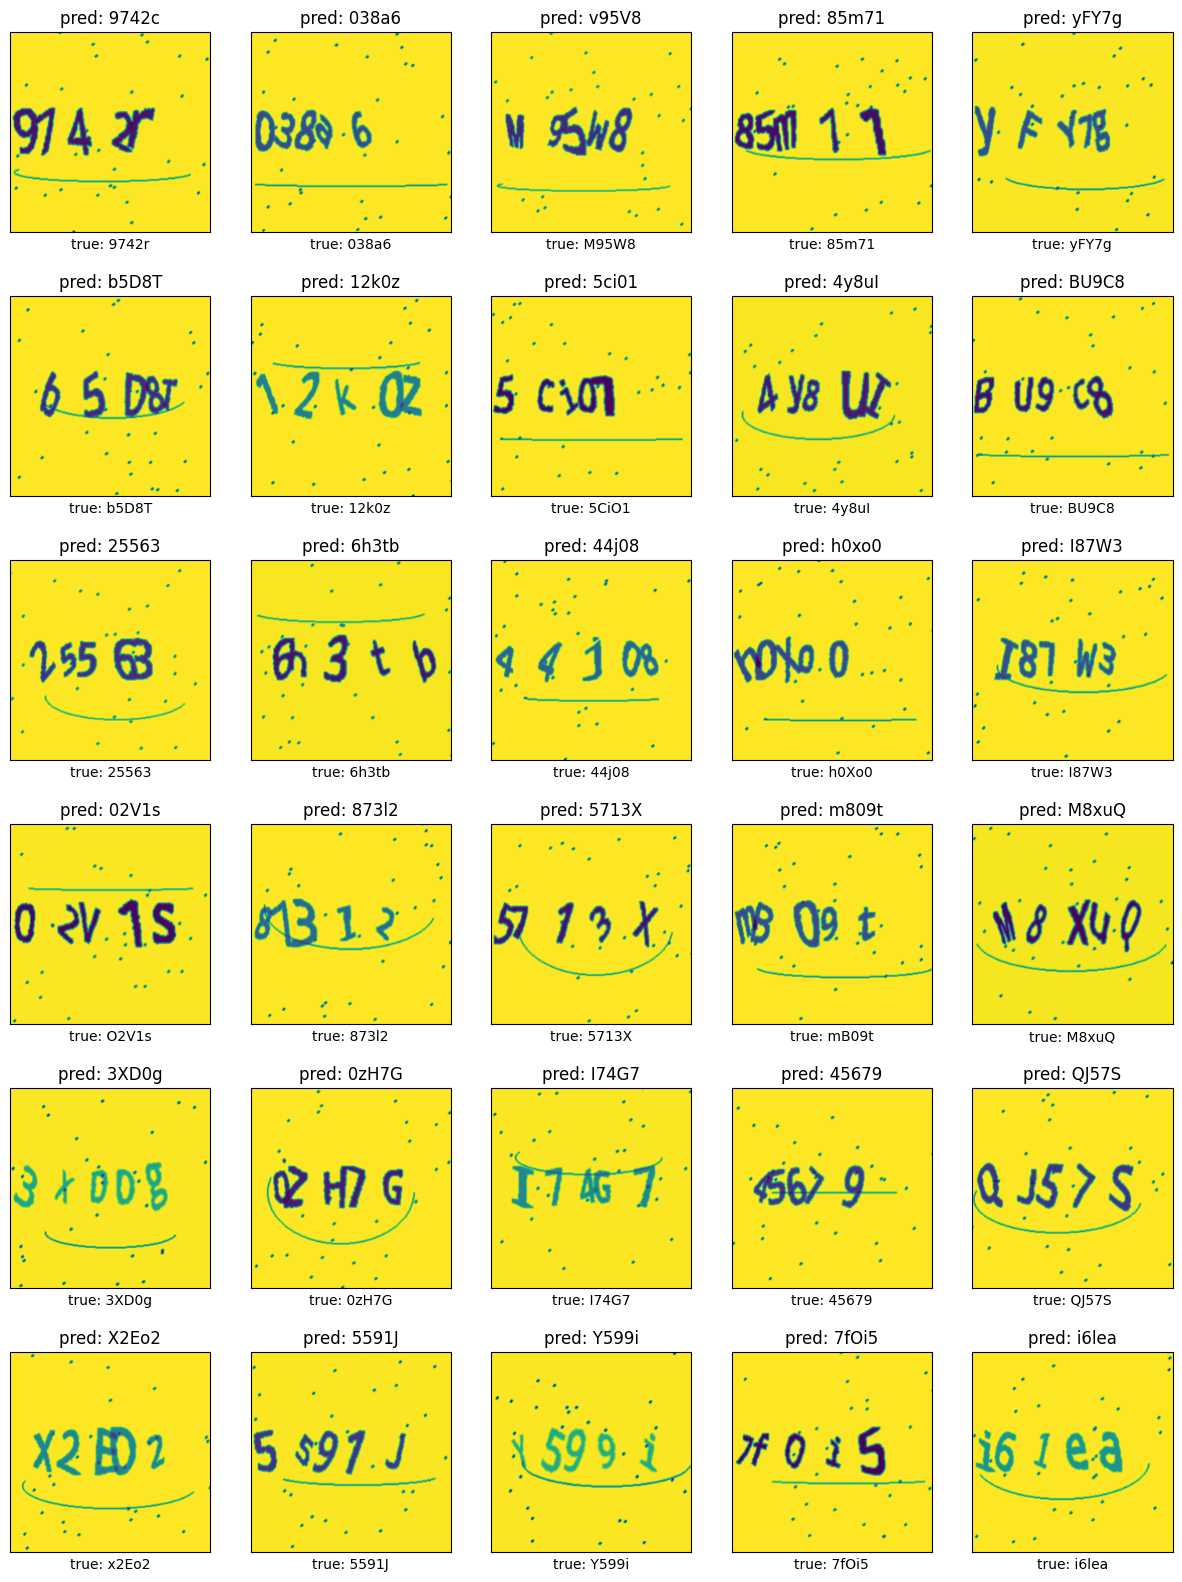

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])  # Specify the 'gray' color map
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


Now after this step, I realised theres a small problem with how we evaluate our model. We evaluate an output as correct only if it predicts the label exactly as the target with the correct case also.

Meaning when our model predicts lets say 'o' as 'O' or 's' as 'S' or 'x' as 'X' the output is labelled as wrong, but considering that we're working with captchas, the imgs can be wavy, distored etc. that is a slightly wrong metric.

Even then our model does pretty well with 90%.

What could help is evaluating the model with a uni-case label, either upper/lower case converted and then maybe we would land a better test accuracy.

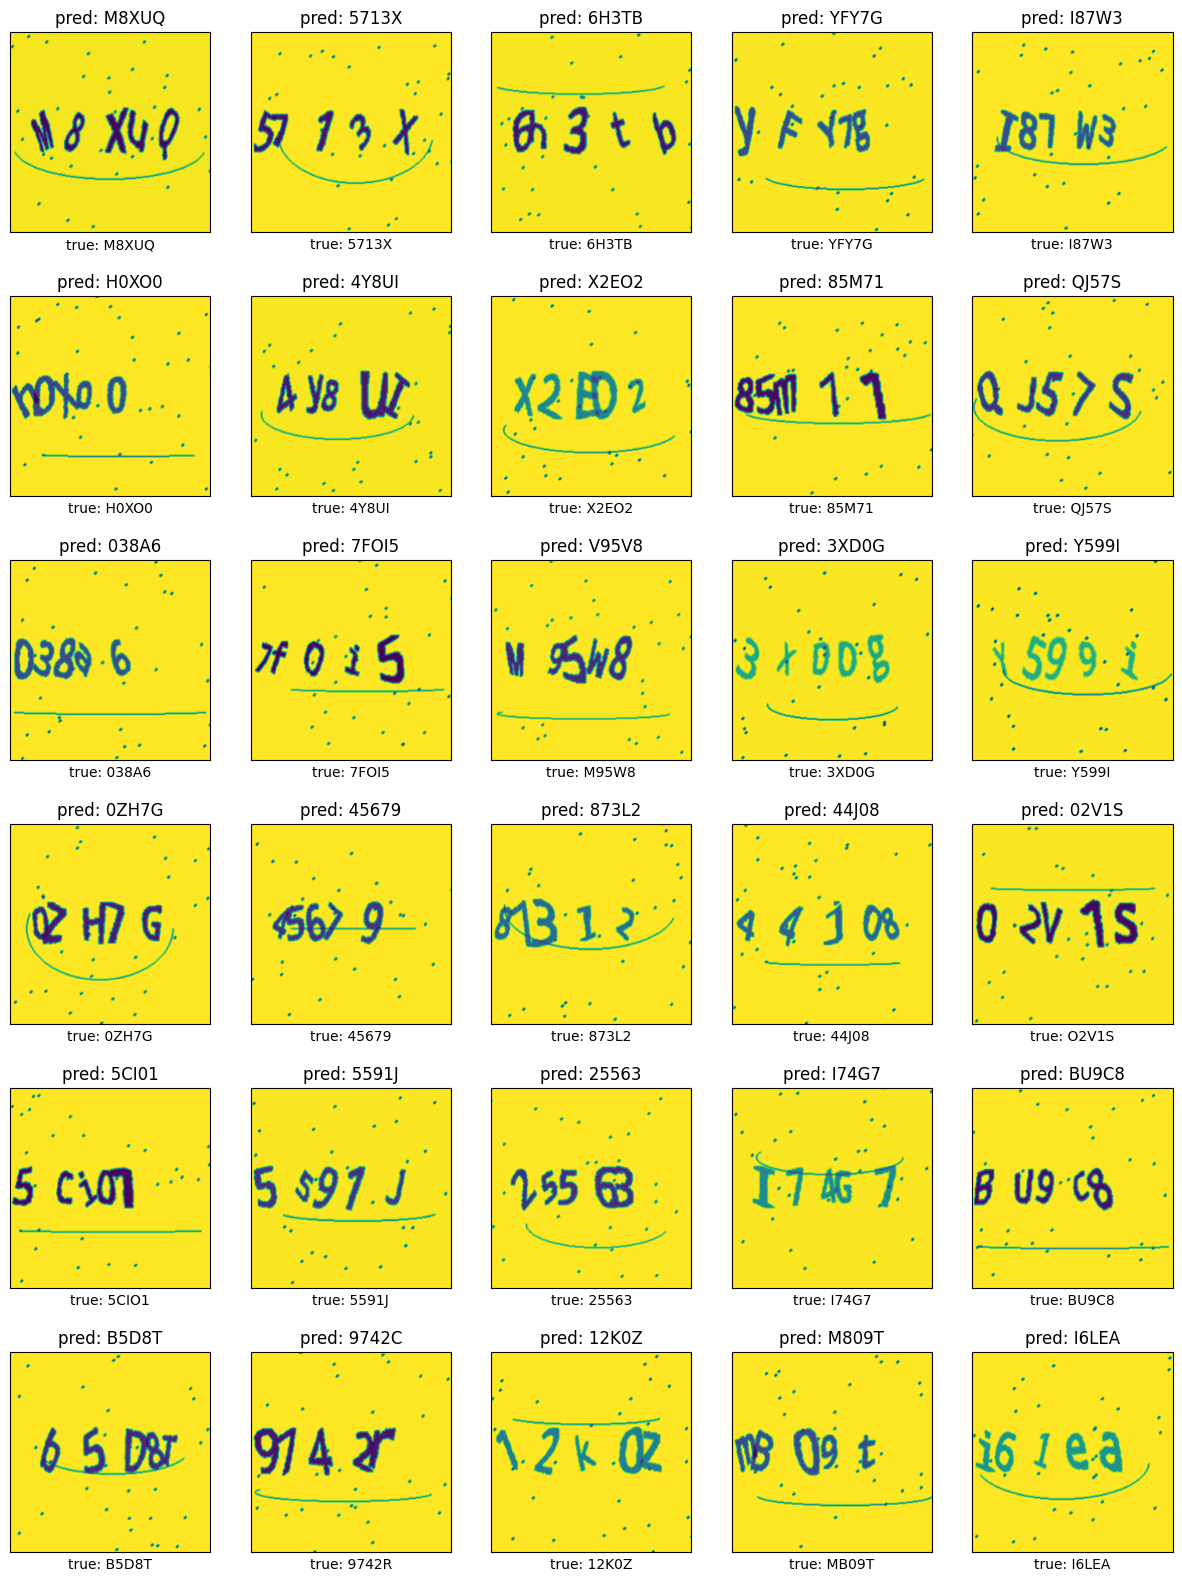

In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])  # Specify the 'gray' color map
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]).upper())
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]).upper())
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


This method of evaluation clearly yields a much better accuracy than that of the actual case.
Now, if we had to set a baseline performance, the closest most accessible OCR tech I could think of is google lens, I manually tested every img above and got the following results  (upper case corrected) :


1. M8X40 | M8XUQ
2. 5713X | 5713X
3. Q3TB  | 6H3TB
4. YFY7G | YFY7G
5. 187W3 | I87W3
6. XOXO.0 | HOXO0
7. AY8UZ | 4Y8UI
8. X2ED2 | X2EO2
9. 8501.1 | 85M71
10. 1599.1 | Y599I

.....

which is less than 30% accuracy on the entire sample above.

So, overall the model did pretty well, I would call it a success.

Hope you liked my project, let me know of any feedback. 😀

BYE!

The following piece of code will help you visualize what successive layers are seeing an input image as..

In [38]:
# import tensorflow as tf
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# def preprocess_image(image_path):
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200), color_mode='grayscale')
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = img_array / 255.0  # Normalize the image
#     img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#     return img_array

# image_path = selected_images[0]
# preprocessed_image = preprocess_image(image_path)
# layer_outputs = [layer.output for layer in model.layers[1:8]]  # Choose the desired intermediate layers
# activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict(preprocessed_image)
# save_dir = 'Intermediate/layer_outputs'

# # Create a directory for each layer's outputs
# os.makedirs(save_dir, exist_ok=True)

# # Save each layer's output as an image
# # for i, layer_activation in enumerate(activations):
# #     for j in range(layer_activation.shape[-1]):
# #         activation = layer_activation[0, :, :, j]
# #         plt.imsave(os.path.join(save_dir, f'layer_{i}_activation_{j}.jpg'), activation, cmap='gray')
# import matplotlib.pyplot as plt

# # Save each layer's output as an image and plot it
# for i, layer_activation in enumerate(activations):
#     for j in range(layer_activation.shape[-1]):
#         activation = layer_activation[0, :, :, j]
#         plt.figure()
#         plt.imshow(activation, cmap='gray')
#         plt.title(f'Layer {i} Activation {j}')
#         plt.axis('off')
#         plt.show()

